In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import os
import math
import random
import pyarrow.parquet as pq

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
def is_parquet_file(filename):
    return (filename[0].endswith(".parquet"))

class LandmarkDataset(Dataset):
    def __init__(self, data, labels):
        
        
        self.labels = torch.LongTensor(labels).to(device)
        self.landmark_filenames = ['/kaggle/input/ml-asl-project/'+x[0] for x in data if is_parquet_file(x)]
        self.data = [torch.FloatTensor(pd.read_parquet(path).values).to(device) for path in tqdm(self.landmark_filenames,desc='Loading data', total=len(self.landmark_filenames))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        
        return self.data[idx], self.labels[idx]

In [5]:
data = pd.read_csv("/kaggle/input/final-train/final_train.csv")
data = data.drop(["Unnamed: 0"], axis = 1)

In [6]:
X = data["path"].values
X = X.reshape(-1,1)
X

array([['dataset4/asl-signs/train_landmark_files/26734/1000035562.parquet'],
       ['dataset4/asl-signs/train_landmark_files/28656/1000106739.parquet'],
       ['dataset4/asl-signs/train_landmark_files/16069/100015657.parquet'],
       ...,
       ['dataset4/asl-signs/train_landmark_files/25571/999833418.parquet'],
       ['dataset4/asl-signs/train_landmark_files/29302/999895257.parquet'],
       ['dataset4/asl-signs/train_landmark_files/36257/999962374.parquet']],
      dtype=object)

In [7]:
Y = data["label"].values
#Y = Y.reshape(-1,1)
Y

array([ 25, 232,  48, ...,  86, 188, 105])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [9]:
print("X shape: ",X.shape)
print("Y shape: ",Y.shape)
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X shape:  (94477, 1)
Y shape:  (94477,)
X_train shape:  (85029, 1)
y_train shape:  (85029,)
X_test shape:  (9448, 1)
y_test shape:  (9448,)


In [10]:
train_dataset = LandmarkDataset(X_train, y_train)
val_dataset = LandmarkDataset(X_test, y_test)

Loading data: 100%|██████████| 9448/9448 [05:16<00:00, 29.84it/s]


In [11]:
train_dataset[0]

(tensor([[ 0.4033,  0.3968,  0.4048,  ...,  0.4906,  0.5191,  0.5397],
         [ 0.3956,  0.3968,  0.3964,  ...,  0.4934,  0.5190,  0.5360],
         [ 0.3928,  0.3844,  0.3925,  ...,  0.4926,  0.5144,  0.5263],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
        device='cuda:0'),
 tensor(168, device='cuda:0'))

In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)#, num_workers=8, drop_last=False, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)#, num_workers=8, drop_last=False, pin_memory=True)

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers, bidirectional, num_classes, batch_first):
        super(LSTMModel,self).__init__()
        self.num_fearturs = num_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_classes = num_classes
        self.batch_first = batch_first
        self.lstm = nn.LSTM(input_size = num_features, hidden_size = hidden_size, num_layers = num_layers, batch_first = batch_first, bidirectional = bidirectional)
        if self.bidirectional:
            self.fc = nn.Linear(hidden_size*2, num_classes)
        else:
            self.fc = nn.Linear(hidden_size, num_classes)
        self.embed = nn.Sequential(
            nn.Linear(num_features, num_features*2, bias = True),
            nn.LayerNorm(num_features*2),
            nn.ReLU(inplace = True),
            nn.Linear(num_features*2, num_features, bias = True),
            nn.LayerNorm(num_features),
            nn.ReLU(inplace = True)
            )
        
    def forward(self, x):
        x = self.embed(x)
        if self.bidirectional:
            h0 = torch.zeros(self.num_layers*2, x.shape[0], self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers*2, x.shape[0], self.hidden_size).to(x.device)
        else:
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

In [5]:
import optuna
from optuna.pruners import MedianPruner

def train(params,save_model, trial):
    learning_rate = 5e-4
    weight_decay = 1e-1
    cycle = 8
    model = LSTMModel(num_features = 176, hidden_size = params["hidden_size"], num_layers = params['num_layers'], 
                  bidirectional = False, num_classes = 250, batch_first = True).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=cycle, eta_min=learning_rate / 10)
    best_loss = float('inf')
    saved_state = model.state_dict()

    epochs = 10
    for epoch in range(epochs):
        acc, loss, v_acc, v_loss = 0,0,0,0
        
        total_batches = len(train_loader)
        train_size, train_batches = 0, 0
        train_loss, train_correct = 0, 0
        val_size, val_batches = 0, 0
        val_loss, val_correct = 0, 0
        n_offset=1

        with tqdm(desc=f'Epoch {epoch+n_offset}', total=total_batches) as bar:

            # Training
            for batch, (src, y) in enumerate(train_loader):

                # Compute prediction and loss
                pred = model(src)
                loss = loss_fn(pred, y)

                # Compute metrics
                train_loss += loss.item()
                train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                train_size += len(y)
                train_batches += 1

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                optimizer.step()

                scheduler.step(epoch + batch / total_batches)

                # Update progress bar
                bar.update()
                bar.set_postfix(accuracy = train_correct / train_size, loss = train_loss / train_batches,
                               lr=scheduler.get_last_lr())

            bar.set_postfix(accuracy = train_correct / train_size, loss = train_loss / train_batches)
            #scheduler.step()

            # Validation
            with torch.no_grad():

                for batch, (src, y) in enumerate(val_loader):

                    # Compute prediction and loss
                    pred = model(src)
                    val_loss += loss_fn(pred, y).item()

                    # Compute metrics
                    val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                    val_size += len(y)
                    val_batches += 1

                    # Update progress bar
                    bar.set_postfix(
                        accuracy = train_correct / train_size, loss = train_loss / train_batches,
                        val_accuracy = val_correct / val_size, val_loss = val_loss / val_batches
                    )
                    
            

        if scheduler.T_0 - scheduler.T_cur < 0.1:
            print()
        acc = train_correct / train_size
        loss = train_loss / train_batches
        v_acc = val_correct / val_size
        v_loss = val_loss / val_batches
        
        
        if v_loss<best_loss:
            best_loss = v_loss
            if save_model:
                saved_state = model.state_dict()
        
        if trial.should_prune():
                raise optuna.TrialPruned()
                
        
            
    return best_loss

def objective(trial):
    params = {
        "hidden_size": trial.suggest_categorical("hidden_size",[64, 96, 128, 160, 192, 256]),
        "num_layers" : trial.suggest_int("num_layers",1,8)
    }
    print(trial.params)
    best_val_loss = train(params, False, trial)
    return best_val_loss

study = optuna.create_study(direction = "minimize", pruner=MedianPruner())
study.optimize(objective, n_trials=20)


[I 2023-04-27 00:32:16,870] A new study created in memory with name: no-name-86b6c8c2-dded-4686-bf36-f469523ee2e6


{'hidden_size': 160, 'num_layers': 5}


Epoch 8: 100%|██████████| 333/333 [00:25<00:00, 13.12it/s, accuracy=0.0232, loss=5, val_accuracy=0.0219, val_loss=5.01]


Epoch 10: 100%|██████████| 333/333 [00:25<00:00, 13.11it/s, accuracy=0.0222, loss=4.99, val_accuracy=0.0238, val_loss=4.98]
[I 2023-04-27 00:36:30,827] Trial 0 finished with value: 4.983493392531936 and parameters: {'hidden_size': 160, 'num_layers': 5}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 96, 'num_layers': 7}


Epoch 8: 100%|██████████| 333/333 [00:21<00:00, 15.79it/s, accuracy=0.00422, loss=5.52, val_accuracy=0.00381, val_loss=5.52]


Epoch 10: 100%|██████████| 333/333 [00:21<00:00, 15.79it/s, accuracy=0.00409, loss=5.52, val_accuracy=0.00328, val_loss=5.52]
[I 2023-04-27 00:40:01,865] Trial 1 finished with value: 5.521474825369345 and parameters: {'hidden_size': 96, 'num_layers': 7}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 96, 'num_layers': 2}


Epoch 8: 100%|██████████| 333/333 [00:09<00:00, 33.68it/s, accuracy=0.00826, loss=5.43, val_accuracy=0.00868, val_loss=5.4] 


Epoch 10: 100%|██████████| 333/333 [00:09<00:00, 33.68it/s, accuracy=0.0085, loss=5.28, val_accuracy=0.0121, val_loss=5.18]
[I 2023-04-27 00:41:40,838] Trial 2 finished with value: 5.177524811512715 and parameters: {'hidden_size': 96, 'num_layers': 2}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 128, 'num_layers': 8}


Epoch 8: 100%|██████████| 333/333 [00:26<00:00, 12.78it/s, accuracy=0.00439, loss=5.52, val_accuracy=0.00434, val_loss=5.52]


Epoch 10: 100%|██████████| 333/333 [00:26<00:00, 12.72it/s, accuracy=0.00412, loss=5.52, val_accuracy=0.00339, val_loss=5.52]
[I 2023-04-27 00:46:02,518] Trial 3 finished with value: 5.522565777237351 and parameters: {'hidden_size': 128, 'num_layers': 8}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 128, 'num_layers': 1}


Epoch 8: 100%|██████████| 333/333 [00:08<00:00, 38.54it/s, accuracy=0.00472, loss=5.52, val_accuracy=0.00466, val_loss=5.52]


Epoch 10: 100%|██████████| 333/333 [00:08<00:00, 38.55it/s, accuracy=0.00442, loss=5.52, val_accuracy=0.00497, val_loss=5.52]
[I 2023-04-27 00:47:28,967] Trial 4 finished with value: 5.519601989436794 and parameters: {'hidden_size': 128, 'num_layers': 1}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 256, 'num_layers': 7}


Epoch 8: 100%|██████████| 333/333 [00:48<00:00,  6.86it/s, accuracy=0.00401, loss=5.52, val_accuracy=0.00296, val_loss=5.52]


Epoch 10: 100%|██████████| 333/333 [00:48<00:00,  6.86it/s, accuracy=0.0042, loss=5.52, val_accuracy=0.00434, val_loss=5.52]
[I 2023-04-27 00:55:34,734] Trial 5 finished with value: 5.522268849450189 and parameters: {'hidden_size': 256, 'num_layers': 7}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 160, 'num_layers': 1}


Epoch 8: 100%|██████████| 333/333 [00:09<00:00, 33.57it/s, accuracy=0.00467, loss=5.52, val_accuracy=0.00455, val_loss=5.52]


Epoch 10: 100%|██████████| 333/333 [00:09<00:00, 33.37it/s, accuracy=0.00585, loss=5.5, val_accuracy=0.00614, val_loss=5.5] 
[I 2023-04-27 00:57:14,042] Trial 6 finished with value: 5.500430493741422 and parameters: {'hidden_size': 160, 'num_layers': 1}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 192, 'num_layers': 6}


Epoch 8: 100%|██████████| 333/333 [00:32<00:00, 10.10it/s, accuracy=0.00479, loss=5.52, val_accuracy=0.00455, val_loss=5.52]


Epoch 10: 100%|██████████| 333/333 [00:32<00:00, 10.11it/s, accuracy=0.00483, loss=5.52, val_accuracy=0.00445, val_loss=5.52]
[I 2023-04-27 01:02:43,526] Trial 7 finished with value: 5.520130299233101 and parameters: {'hidden_size': 192, 'num_layers': 6}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 128, 'num_layers': 1}


Epoch 8: 100%|██████████| 333/333 [00:08<00:00, 38.63it/s, accuracy=0.00462, loss=5.52, val_accuracy=0.00318, val_loss=5.52]


Epoch 10: 100%|██████████| 333/333 [00:08<00:00, 38.42it/s, accuracy=0.00619, loss=5.49, val_accuracy=0.00519, val_loss=5.5] 
[I 2023-04-27 01:04:10,080] Trial 8 finished with value: 5.499425475661819 and parameters: {'hidden_size': 128, 'num_layers': 1}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 192, 'num_layers': 4}


Epoch 8: 100%|██████████| 333/333 [00:23<00:00, 14.08it/s, accuracy=0.00501, loss=5.51, val_accuracy=0.00392, val_loss=5.52]


Epoch 10: 100%|██████████| 333/333 [00:23<00:00, 14.13it/s, accuracy=0.00497, loss=5.51, val_accuracy=0.00466, val_loss=5.52]
[I 2023-04-27 01:08:06,418] Trial 9 finished with value: 5.520587315430513 and parameters: {'hidden_size': 192, 'num_layers': 4}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 64, 'num_layers': 4}


Epoch 8: 100%|██████████| 333/333 [00:10<00:00, 30.51it/s, accuracy=0.00982, loss=5.3, val_accuracy=0.00773, val_loss=5.28]


Epoch 10: 100%|██████████| 333/333 [00:10<00:00, 32.64it/s, accuracy=0.0122, loss=5.2, val_accuracy=0.0135, val_loss=5.16] 
[I 2023-04-27 01:09:49,335] Trial 10 finished with value: 5.161530945752118 and parameters: {'hidden_size': 64, 'num_layers': 4}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 64, 'num_layers': 4}


Epoch 8: 100%|██████████| 333/333 [00:10<00:00, 31.55it/s, accuracy=0.00803, loss=5.4, val_accuracy=0.0073, val_loss=5.37] 


Epoch 10: 100%|██████████| 333/333 [00:10<00:00, 32.85it/s, accuracy=0.0109, loss=5.24, val_accuracy=0.0109, val_loss=5.2] 
[I 2023-04-27 01:11:32,082] Trial 11 finished with value: 5.19819536724606 and parameters: {'hidden_size': 64, 'num_layers': 4}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 64, 'num_layers': 5}


Epoch 8: 100%|██████████| 333/333 [00:13<00:00, 25.36it/s, accuracy=0.00603, loss=5.49, val_accuracy=0.00497, val_loss=5.5] 


Epoch 10: 100%|██████████| 333/333 [00:12<00:00, 25.83it/s, accuracy=0.0071, loss=5.44, val_accuracy=0.00794, val_loss=5.35]
[I 2023-04-27 01:13:41,426] Trial 12 finished with value: 5.354805675712791 and parameters: {'hidden_size': 64, 'num_layers': 5}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 160, 'num_layers': 3}


Epoch 8: 100%|██████████| 333/333 [00:17<00:00, 18.58it/s, accuracy=0.0127, loss=5.2, val_accuracy=0.0145, val_loss=5.19]


Epoch 10: 100%|██████████| 333/333 [00:17<00:00, 18.53it/s, accuracy=0.0161, loss=5.12, val_accuracy=0.0199, val_loss=5.06]
[I 2023-04-27 01:16:40,402] Trial 13 finished with value: 5.05655337668754 and parameters: {'hidden_size': 160, 'num_layers': 3}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 160, 'num_layers': 3}


Epoch 8: 100%|██████████| 333/333 [00:17<00:00, 18.63it/s, accuracy=0.00941, loss=5.36, val_accuracy=0.00942, val_loss=5.34]


Epoch 10: 100%|██████████| 333/333 [00:17<00:00, 18.53it/s, accuracy=0.0113, loss=5.22, val_accuracy=0.0114, val_loss=5.25] 
[I 2023-04-27 01:19:39,732] Trial 14 finished with value: 5.245254787238869 and parameters: {'hidden_size': 160, 'num_layers': 3}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 160, 'num_layers': 3}


Epoch 8: 100%|██████████| 333/333 [00:18<00:00, 18.47it/s, accuracy=0.00492, loss=5.52, val_accuracy=0.00402, val_loss=5.52]


Epoch 10: 100%|██████████| 333/333 [00:17<00:00, 18.62it/s, accuracy=0.00485, loss=5.52, val_accuracy=0.00392, val_loss=5.52]
[I 2023-04-27 01:22:39,679] Trial 15 finished with value: 5.521239345138137 and parameters: {'hidden_size': 160, 'num_layers': 3}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 160, 'num_layers': 5}


Epoch 8: 100%|██████████| 333/333 [00:25<00:00, 13.04it/s, accuracy=0.00942, loss=5.35, val_accuracy=0.0106, val_loss=5.37] 


Epoch 10: 100%|██████████| 333/333 [00:25<00:00, 13.11it/s, accuracy=0.0122, loss=5.19, val_accuracy=0.00942, val_loss=5.22]
[I 2023-04-27 01:26:54,177] Trial 16 finished with value: 5.223115070446117 and parameters: {'hidden_size': 160, 'num_layers': 5}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 160, 'num_layers': 3}


Epoch 8: 100%|██████████| 333/333 [00:17<00:00, 18.63it/s, accuracy=0.00837, loss=5.4, val_accuracy=0.00826, val_loss=5.36]


Epoch 10: 100%|██████████| 333/333 [00:17<00:00, 18.65it/s, accuracy=0.0134, loss=5.18, val_accuracy=0.0121, val_loss=5.19]
[I 2023-04-27 01:29:52,599] Trial 17 finished with value: 5.19024185232214 and parameters: {'hidden_size': 160, 'num_layers': 3}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 256, 'num_layers': 6}


Epoch 8: 100%|██████████| 333/333 [00:43<00:00,  7.74it/s, accuracy=0.00406, loss=5.52, val_accuracy=0.00296, val_loss=5.52]


Epoch 10: 100%|██████████| 333/333 [00:43<00:00,  7.73it/s, accuracy=0.00425, loss=5.52, val_accuracy=0.0036, val_loss=5.52] 
[I 2023-04-27 01:37:03,432] Trial 18 finished with value: 5.522360402184564 and parameters: {'hidden_size': 256, 'num_layers': 6}. Best is trial 0 with value: 4.983493392531936.


{'hidden_size': 160, 'num_layers': 2}


Epoch 8: 100%|██████████| 333/333 [00:14<00:00, 23.06it/s, accuracy=0.00896, loss=5.32, val_accuracy=0.00889, val_loss=5.3] 


Epoch 10: 100%|██████████| 333/333 [00:14<00:00, 23.08it/s, accuracy=0.0119, loss=5.19, val_accuracy=0.0162, val_loss=5.14]
[I 2023-04-27 01:39:27,596] Trial 19 finished with value: 5.14094877243042 and parameters: {'hidden_size': 160, 'num_layers': 2}. Best is trial 0 with value: 4.983493392531936.


In [7]:
from optuna.trial import TrialState

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))


print("Best trial:")
trial_ = study.best_trial

print("  Value: ", trial_.value)

print("  Params: ")
for key, value in trial_.params.items():
    print("    {}: {}".format(key,value))

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  0
  Number of complete trials:  20
Best trial:
  Value:  4.983493392531936
  Params: 
    hidden_size: 160
    num_layers: 5


In [8]:
# Visualize the optimization history.
from optuna.visualization import plot_contour
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
plot_optimization_history(study).show()

In [9]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study).show()

In [10]:
plot_contour(study).show()

In [11]:
plot_slice(study).show()

In [12]:
# Visualize parameter importances.
plot_param_importances(study).show()

Training the model with the hyperparameters obtained for the best trial

In [16]:
num_features = 176
hidden_size = 160
num_layers = 5
num_classes = 250
model = LSTMModel(num_features = num_features, hidden_size = hidden_size, num_layers = num_layers, 
                  bidirectional = True, num_classes = num_classes, batch_first = True).to(device)

In [17]:
learning_rate = 5e-4
weight_decay = 1e-1
cycle = 8

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=cycle, eta_min=learning_rate / 10)

train_losses = []
val_losses = []

def train_val_loop(epoch, train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler, n_offset=1):
    total_batches = len(train_dataloader)
    train_size, train_batches = 0, 0
    train_loss, train_correct = 0, 0
    val_size, val_batches = 0, 0
    val_loss, val_correct = 0, 0
    
    with tqdm(desc=f'Epoch {epoch+n_offset}', total=total_batches) as bar:
        
        # Training
        for batch, (src, y) in enumerate(train_dataloader):
            
            # Compute prediction and loss
            pred = model(src)
            loss = loss_fn(pred, y)
            
            # Compute metrics
            train_loss += loss.item()
            train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_size += len(y)
            train_batches += 1

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
                
            scheduler.step(epoch + batch / total_batches)
            
            # Update progress bar
            bar.update()
            bar.set_postfix(accuracy = train_correct / train_size, loss = train_loss / train_batches,
                           lr=scheduler.get_last_lr())
            
        bar.set_postfix(accuracy = train_correct / train_size, loss = train_loss / train_batches)
        
        #scheduler.step()
           
        # Validation
        with torch.no_grad():

            for batch, (src, y) in enumerate(val_dataloader):
                
                # Compute prediction and loss
                pred = model(src)
                val_loss += loss_fn(pred, y).item()
                
                # Compute metrics
                val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                val_size += len(y)
                val_batches += 1

                # Update progress bar
                bar.set_postfix(
                    accuracy = train_correct / train_size, loss = train_loss / train_batches,
                    val_accuracy = val_correct / val_size, val_loss = val_loss / val_batches
                )
                
    if scheduler.T_0 - scheduler.T_cur < 0.1:
        print()
        
    train_losses.append(train_loss / train_batches)
    val_losses.append(val_loss / val_batches)

    return train_correct / train_size, train_loss / train_batches, val_correct / val_size, val_loss / val_batches


best_loss = float('inf')
saved_state = model.state_dict()

epochs = 300


#model.load_state_dict(torch.load("/kaggle/input/lstm-model/lstm_model_100Epochs_ss.pth"))
# Iterate through epochs for training
for epoch in range(epochs):
    
    acc, loss, v_acc, v_loss = train_val_loop(epoch, train_loader, val_loader, model, loss_fn, optimizer, scheduler)
    if (epoch + 1) % 50 == 0:
        torch.save(model.state_dict(), 'lstm_model_' + str(epoch+1))
    if v_loss<best_loss:
        best_loss = v_loss
        saved_state = model.state_dict()

Epoch 8: 100%|██████████| 665/665 [01:35<00:00,  6.96it/s, accuracy=0.0166, loss=5.11, val_accuracy=0.015, val_loss=5.1]   


Epoch 16: 100%|██████████| 665/665 [01:35<00:00,  6.96it/s, accuracy=0.0736, loss=4.4, val_accuracy=0.0658, val_loss=4.44]


Epoch 24: 100%|██████████| 665/665 [01:35<00:00,  6.97it/s, accuracy=0.148, loss=3.87, val_accuracy=0.147, val_loss=3.91]


Epoch 32: 100%|██████████| 665/665 [01:35<00:00,  6.96it/s, accuracy=0.28, loss=3.08, val_accuracy=0.266, val_loss=3.17]


Epoch 40: 100%|██████████| 665/665 [01:35<00:00,  6.97it/s, accuracy=0.372, loss=2.62, val_accuracy=0.343, val_loss=2.78]


Epoch 48: 100%|██████████| 665/665 [01:35<00:00,  6.95it/s, accuracy=0.446, loss=2.29, val_accuracy=0.4, val_loss=2.52]  


Epoch 56: 100%|██████████| 665/665 [01:35<00:00,  6.94it/s, accuracy=0.503, loss=2.04, val_accuracy=0.451, val_loss=2.3] 


Epoch 64: 100%|██████████| 665/665 [01:36<00:00,  6.90it/s, accuracy=0.557, loss=1.82, val_accuracy=0.488, val_loss=2.15]


Epoch 72: 100%|██████████| 665/665 [01:35<00:00,  6.95it/s, accuracy=0.605, loss=1.63, val_accuracy=0.517, val_loss=2.03]


Epoch 80: 100%|██████████| 665/665 [01:34<00:00,  7.00it/s, accuracy=0.643, loss=1.47, val_accuracy=0.54, val_loss=1.92] 


Epoch 88: 100%|██████████| 665/665 [01:34<00:00,  7.03it/s, accuracy=0.679, loss=1.33, val_accuracy=0.56, val_loss=1.86] 


Epoch 96: 100%|██████████| 665/665 [01:35<00:00,  6.98it/s, accuracy=0.709, loss=1.22, val_accuracy=0.572, val_loss=1.81]


Epoch 104: 100%|██████████| 665/665 [01:35<00:00,  6.95it/s, accuracy=0.736, loss=1.12, val_accuracy=0.579, val_loss=1.8] 


Epoch 112: 100%|██████████| 665/665 [01:35<00:00,  6.98it/s, accuracy=0.761, loss=1.03, val_accuracy=0.588, val_loss=1.78]


Epoch 120: 100%|██████████| 665/665 [01:35<00:00,  6.98it/s, accuracy=0.783, loss=0.949, val_accuracy=0.593, val_loss=1.76]


Epoch 128: 100%|██████████| 665/665 [01:35<00:00,  6.98it/s, accuracy=0.799, loss=0.885, val_accuracy=0.603, val_loss=1.74]


Epoch 136: 100%|██████████| 665/665 [01:34<00:00,  7.00it/s, accuracy=0.815, loss=0.825, val_accuracy=0.601, val_loss=1.75]


Epoch 144: 100%|██████████| 665/665 [01:35<00:00,  6.97it/s, accuracy=0.83, loss=0.77, val_accuracy=0.601, val_loss=1.78]


Epoch 152: 100%|██████████| 665/665 [01:35<00:00,  6.96it/s, accuracy=0.844, loss=0.723, val_accuracy=0.604, val_loss=1.77]


Epoch 160: 100%|██████████| 665/665 [01:35<00:00,  6.94it/s, accuracy=0.853, loss=0.685, val_accuracy=0.606, val_loss=1.75]


Epoch 168: 100%|██████████| 665/665 [01:35<00:00,  6.95it/s, accuracy=0.864, loss=0.646, val_accuracy=0.61, val_loss=1.78] 


Epoch 176: 100%|██████████| 665/665 [01:35<00:00,  6.94it/s, accuracy=0.873, loss=0.614, val_accuracy=0.606, val_loss=1.81]


Epoch 184: 100%|██████████| 665/665 [01:35<00:00,  6.96it/s, accuracy=0.88, loss=0.583, val_accuracy=0.607, val_loss=1.8] 


Epoch 192: 100%|██████████| 665/665 [01:34<00:00,  7.01it/s, accuracy=0.888, loss=0.555, val_accuracy=0.61, val_loss=1.82] 


Epoch 200: 100%|██████████| 665/665 [01:35<00:00,  6.96it/s, accuracy=0.895, loss=0.531, val_accuracy=0.61, val_loss=1.82] 


Epoch 208: 100%|██████████| 665/665 [01:35<00:00,  6.99it/s, accuracy=0.902, loss=0.507, val_accuracy=0.609, val_loss=1.86]


KeyboardInterrupt: 

In [18]:
torch.save(model.state_dict(),"LSTMFinalModel.pth")
torch.save(saved_state,"LSTMBestModelFinal.pth")

In [23]:
len(train_losses)

207

In [25]:
len(val_losses)

207

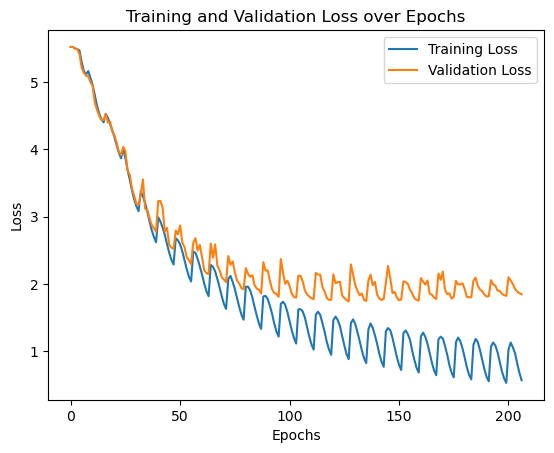

In [26]:
# Plotting
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [14]:
cd 

__notebook_source__.ipynb  state.db


In [24]:
print(f"Testing the Best Model on Validation Set: ")

test_loss = 0.0
test_acc = 0.0

num_features = 176
hidden_size = 160
num_layers = 5
num_classes = 250
model = LSTMModel(num_features = num_features, hidden_size = hidden_size, num_layers = num_layers, 
                  bidirectional = True, num_classes = num_classes, batch_first = True).to(device)
model.load_state_dict(torch.load("/kaggle/input/lstm-best-final/LSTMBestModelFinal.pth"))
loss_fn = nn.CrossEntropyLoss()

with torch.no_grad():
    
    for data, labels in val_loader:
        outputs = model(data)
        loss = loss_fn(outputs, labels)
        test_loss +=loss.item()
        _,gt = torch.max(outputs,1)
        test_acc += torch.sum(labels==gt)

    test_loss = test_loss/(len(val_loader)*128)
    test_acc = test_acc/(len(val_loader)*128)


    print(f'\tTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Testing the Best Model on Validation Set: 
	Test Loss: 0.0145, Test Accuracy: 0.6071


In [25]:
def get_mean_classification_accuracy(dataloader):
    
    acc=[]
    with torch.no_grad():
        
        batch = 0
        mean_acc = 0.0
        for data, labels in dataloader:
            
            correct_preds = 0
            total_preds = 0
            
            batch = batch + 1
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs,1)
            correct_preds = correct_preds + torch.sum(preds==labels.data)
            total_preds = labels.size(0)
            acc.append(correct_preds/total_preds)
        mean_acc = torch.mean(torch.tensor(acc))
        return mean_acc
mean_acc_on_val_set = get_mean_classification_accuracy(val_loader)
mean_acc_on_train_set = get_mean_classification_accuracy(train_loader)

print(f'Mean Classification Accuracy on Train Set: {100*mean_acc_on_train_set:.4f}')
print(f'Mean Classification Accuracy on Validation Set: {100*mean_acc_on_val_set:.4f}')

Mean Classification Accuracy on Train Set: 91.0049
Mean Classification Accuracy on Validation Set: 60.8636


In [27]:
def get_mean_per_class_accuracy(dataloader):
    with torch.no_grad():
        class_acc = [[] for i in range(250)]
        
        num_classes = 250
        class_correct = [0] * num_classes
        class_total = [0] * num_classes
        for data, labels in dataloader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            for i in range(num_classes):
                if class_total[i]==0:
                    class_acc[i].append(0)
                else:
                    class_acc[i].append(class_correct[i]/class_total[i])
        mean_per_class_acc_list = [torch.mean(torch.tensor(class_acc[i])) for i in range(len(class_acc))]
        return mean_per_class_acc_list
    
import json
def read_json(path):
    with open(path, "r") as file:
        json_data = json.load(file)
    return json_data

s2p_map = read_json(os.path.join("/kaggle/input/sign-to-pred/sign_to_prediction_index_map.json"))
p2s_map = {v: k for k, v in s2p_map.items()}

encoder = lambda x: s2p_map.get(x)
decoder = lambda x: p2s_map.get(x)


print('Mean per class accuracies for the train set: ')
train_mean_per_class_acc = get_mean_per_class_accuracy(train_loader)
for i in range(len(train_mean_per_class_acc)):
    print(f'{p2s_map[i]}: {100*train_mean_per_class_acc[i]:.4f}')
    
print('Mean per class accuracies for the validation set: ')
val_mean_per_class_acc = get_mean_per_class_accuracy(val_loader)
for i in range(len(val_mean_per_class_acc)):
    print(f'{p2s_map[i]}: {100*val_mean_per_class_acc[i]:.4f}')

Mean per class accuracies for the train set: 
TV: 94.1737
after: 89.4439
airplane: 90.3677
all: 89.7665
alligator: 91.7978
animal: 83.0499
another: 93.4681
any: 92.5374
apple: 92.4334
arm: 91.9120
aunt: 88.1760
awake: 82.1475
backyard: 88.1145
bad: 91.2642
balloon: 89.3557
bath: 86.2491
because: 94.9661
bed: 90.5418
bedroom: 88.2997
bee: 92.6582
before: 88.8988
beside: 85.4884
better: 93.2278
bird: 94.8330
black: 94.0474
blow: 92.7690
blue: 92.0544
boat: 87.7916
book: 89.7409
boy: 90.4888
brother: 94.0462
brown: 92.3186
bug: 96.0853
bye: 93.4370
callonphone: 93.0413
can: 90.6289
car: 93.0691
carrot: 92.4366
cat: 92.7914
cereal: 88.5232
chair: 85.1005
cheek: 88.0806
child: 89.4902
chin: 84.1703
chocolate: 91.6776
clean: 91.7321
close: 87.1644
closet: 89.2115
cloud: 94.5443
clown: 94.7730
cow: 93.5093
cowboy: 91.4520
cry: 88.4667
cut: 89.9021
cute: 91.9506
dad: 91.0352
dance: 87.4305
dirty: 93.9280
dog: 89.7634
doll: 93.6287
donkey: 91.7739
down: 89.3438
drawer: 92.9777
drink: 94.8123
dr

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [v for k,v in p2s_map.items()],
                     columns = [v for k,v in p2s_map.items()])
plt.figure(figsize = (250,250))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

In [ ]:
plt.savefig('output.png')

In [16]:
num_features = 176
hidden_size = 256
num_layers = 4
num_classes = 250
model = LSTMModel(num_features = num_features, hidden_size = hidden_size, num_layers = num_layers, 
                  bidirectional = True, num_classes = num_classes, batch_first = True).to(device)

In [17]:
learning_rate = 5e-4
weight_decay = 1e-1
cycle = 8

loss_fn = nn.CrossEntropyLoss()
model.load_state_dict(torch.load("/kaggle/input/lstm-model/lstm_model_100Epochs_ss.pth"))
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=cycle, eta_min=learning_rate / 10)

train_losses = []
val_losses = []

def train_val_loop(epoch, train_dataloader, val_dataloader, model, loss_fn, optimizer, scheduler, n_offset=1):
    total_batches = len(train_dataloader)
    train_size, train_batches = 0, 0
    train_loss, train_correct = 0, 0
    val_size, val_batches = 0, 0
    val_loss, val_correct = 0, 0
    
    with tqdm(desc=f'Epoch {epoch+n_offset}', total=total_batches) as bar:
        
        # Training
        for batch, (src, y) in enumerate(train_dataloader):
            
            # Compute prediction and loss
            pred = model(src)
            loss = loss_fn(pred, y)
            
            # Compute metrics
            train_loss += loss.item()
            train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_size += len(y)
            train_batches += 1

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
                
            scheduler.step(epoch + batch / total_batches)
            
            # Update progress bar
            bar.update()
            bar.set_postfix(accuracy = train_correct / train_size, loss = train_loss / train_batches,
                           lr=scheduler.get_last_lr())
            
        bar.set_postfix(accuracy = train_correct / train_size, loss = train_loss / train_batches)
        
        #scheduler.step()
           
        # Validation
        with torch.no_grad():

            for batch, (src, y) in enumerate(val_dataloader):
                
                # Compute prediction and loss
                pred = model(src)
                val_loss += loss_fn(pred, y).item()
                
                # Compute metrics
                val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                val_size += len(y)
                val_batches += 1

                # Update progress bar
                bar.set_postfix(
                    accuracy = train_correct / train_size, loss = train_loss / train_batches,
                    val_accuracy = val_correct / val_size, val_loss = val_loss / val_batches
                )
                
    if scheduler.T_0 - scheduler.T_cur < 0.1:
        print()
        
    train_losses.append(train_loss / train_batches)
    val_losses.append(val_loss / val_batches)

    return train_correct / train_size, train_loss / train_batches, val_correct / val_size, val_loss / val_batches


best_loss = float('inf')
saved_state = model.state_dict()

epochs = 300


#model.load_state_dict(torch.load("/kaggle/input/lstm-model/lstm_model_100Epochs_ss.pth"))
# Iterate through epochs for training
for epoch in range(epochs):
    
    acc, loss, v_acc, v_loss = train_val_loop(epoch, train_loader, val_loader, model, loss_fn, optimizer, scheduler)
    if (epoch + 1) % 50 == 0:
        torch.save(model.state_dict(), 'lstm_model_' + str(epoch+1))
    if v_loss<best_loss:
        best_loss = v_loss
        saved_state = model.state_dict()

Epoch 8: 100%|██████████| 333/333 [01:26<00:00,  3.83it/s, accuracy=0.76, loss=1.04, val_accuracy=0.511, val_loss=2.14]


Epoch 16: 100%|██████████| 333/333 [01:26<00:00,  3.83it/s, accuracy=0.792, loss=0.925, val_accuracy=0.51, val_loss=2.17] 


Epoch 24: 100%|██████████| 333/333 [01:27<00:00,  3.81it/s, accuracy=0.822, loss=0.824, val_accuracy=0.516, val_loss=2.17]


Epoch 32: 100%|██████████| 333/333 [01:26<00:00,  3.83it/s, accuracy=0.845, loss=0.742, val_accuracy=0.519, val_loss=2.19]


Epoch 40: 100%|██████████| 333/333 [01:27<00:00,  3.82it/s, accuracy=0.868, loss=0.665, val_accuracy=0.523, val_loss=2.22]


Epoch 48: 100%|██████████| 333/333 [01:27<00:00,  3.81it/s, accuracy=0.885, loss=0.605, val_accuracy=0.524, val_loss=2.22]


Epoch 56: 100%|██████████| 333/333 [01:27<00:00,  3.81it/s, accuracy=0.899, loss=0.553, val_accuracy=0.523, val_loss=2.27]


Epoch 64: 100%|██████████| 333/333 [01:27<00:00,  3.82it/s, accuracy=0.912, loss=0.508, val_accuracy=0.524, val_loss=2.3] 


Epoch 72: 100%|██████████| 333/333 [01:26<00:00,  3.84it/s, accuracy=0.921, loss=0.468, val_accuracy=0.522, val_loss=2.33]


Epoch 80: 100%|██████████| 333/333 [01:26<00:00,  3.84it/s, accuracy=0.928, loss=0.437, val_accuracy=0.527, val_loss=2.33]


Epoch 88: 100%|██████████| 333/333 [01:27<00:00,  3.82it/s, accuracy=0.934, loss=0.411, val_accuracy=0.53, val_loss=2.36] 


Epoch 96: 100%|██████████| 333/333 [01:27<00:00,  3.80it/s, accuracy=0.939, loss=0.388, val_accuracy=0.527, val_loss=2.41]


Epoch 104: 100%|██████████| 333/333 [01:26<00:00,  3.86it/s, accuracy=0.942, loss=0.371, val_accuracy=0.53, val_loss=2.4]  


Epoch 112: 100%|██████████| 333/333 [01:27<00:00,  3.80it/s, accuracy=0.944, loss=0.358, val_accuracy=0.529, val_loss=2.43]


Epoch 120: 100%|██████████| 333/333 [01:26<00:00,  3.83it/s, accuracy=0.946, loss=0.345, val_accuracy=0.53, val_loss=2.44] 


Epoch 128: 100%|██████████| 333/333 [01:27<00:00,  3.81it/s, accuracy=0.947, loss=0.337, val_accuracy=0.533, val_loss=2.46]


Epoch 136: 100%|██████████| 333/333 [01:27<00:00,  3.81it/s, accuracy=0.948, loss=0.329, val_accuracy=0.535, val_loss=2.47]


Epoch 144: 100%|██████████| 333/333 [01:26<00:00,  3.85it/s, accuracy=0.948, loss=0.323, val_accuracy=0.534, val_loss=2.49]


Epoch 152: 100%|██████████| 333/333 [01:27<00:00,  3.80it/s, accuracy=0.948, loss=0.317, val_accuracy=0.531, val_loss=2.51]


Epoch 160: 100%|██████████| 333/333 [01:27<00:00,  3.80it/s, accuracy=0.949, loss=0.312, val_accuracy=0.535, val_loss=2.52]


Epoch 168: 100%|██████████| 333/333 [01:27<00:00,  3.80it/s, accuracy=0.949, loss=0.31, val_accuracy=0.541, val_loss=2.51]


Epoch 176: 100%|██████████| 333/333 [01:27<00:00,  3.80it/s, accuracy=0.949, loss=0.307, val_accuracy=0.534, val_loss=2.53]


Epoch 184: 100%|██████████| 333/333 [01:27<00:00,  3.83it/s, accuracy=0.949, loss=0.303, val_accuracy=0.539, val_loss=2.53]


Epoch 192: 100%|██████████| 333/333 [01:27<00:00,  3.81it/s, accuracy=0.949, loss=0.304, val_accuracy=0.541, val_loss=2.54]


Epoch 200: 100%|██████████| 333/333 [01:26<00:00,  3.84it/s, accuracy=0.95, loss=0.298, val_accuracy=0.535, val_loss=2.57]


Epoch 208: 100%|██████████| 333/333 [01:27<00:00,  3.81it/s, accuracy=0.95, loss=0.297, val_accuracy=0.539, val_loss=2.58]


Epoch 216: 100%|██████████| 333/333 [01:27<00:00,  3.82it/s, accuracy=0.95, loss=0.297, val_accuracy=0.537, val_loss=2.58]


Epoch 224: 100%|██████████| 333/333 [01:26<00:00,  3.86it/s, accuracy=0.949, loss=0.296, val_accuracy=0.54, val_loss=2.57] 


Epoch 232: 100%|██████████| 333/333 [01:27<00:00,  3.82it/s, accuracy=0.95, loss=0.294, val_accuracy=0.539, val_loss=2.57]


Epoch 240: 100%|██████████| 333/333 [01:26<00:00,  3.84it/s, accuracy=0.95, loss=0.292, val_accuracy=0.543, val_loss=2.57]


Epoch 248: 100%|██████████| 333/333 [01:27<00:00,  3.81it/s, accuracy=0.95, loss=0.291, val_accuracy=0.542, val_loss=2.58]


Epoch 256: 100%|██████████| 333/333 [01:26<00:00,  3.86it/s, accuracy=0.95, loss=0.291, val_accuracy=0.544, val_loss=2.59]


Epoch 264: 100%|██████████| 333/333 [01:27<00:00,  3.82it/s, accuracy=0.95, loss=0.29, val_accuracy=0.544, val_loss=2.6] 


Epoch 272: 100%|██████████| 333/333 [01:27<00:00,  3.82it/s, accuracy=0.95, loss=0.289, val_accuracy=0.544, val_loss=2.59]


Epoch 280: 100%|██████████| 333/333 [01:27<00:00,  3.81it/s, accuracy=0.95, loss=0.288, val_accuracy=0.545, val_loss=2.61]


Epoch 288: 100%|██████████| 333/333 [01:27<00:00,  3.82it/s, accuracy=0.95, loss=0.288, val_accuracy=0.543, val_loss=2.6] 


Epoch 296: 100%|██████████| 333/333 [01:26<00:00,  3.86it/s, accuracy=0.95, loss=0.287, val_accuracy=0.542, val_loss=2.63]


Epoch 300: 100%|██████████| 333/333 [01:27<00:00,  3.82it/s, accuracy=0.896, loss=0.483, val_accuracy=0.509, val_loss=2.63]


In [19]:
torch.save(model.state_dict(), 'lstm_model_' + str(300))

In [31]:
torch.save(model.state_dict(), 'lstm_model_100Epochs.pth')


In [32]:
torch.save(saved_state, 'lstm_model_100Epochs_ss.pth')

In [30]:
model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 0.0864,  0.0119,  0.1229,  ..., -0.0498, -0.0056,  0.1881],
                      [ 0.0817,  0.0473, -0.0083,  ..., -0.1880,  0.0184,  0.0378],
                      [ 0.0567, -0.0426,  0.0238,  ...,  0.0863,  0.0587,  0.0775],
                      ...,
                      [ 0.0803,  0.0377,  0.0656,  ..., -0.0336, -0.0406,  0.0663],
                      [ 0.0114,  0.0700,  0.0495,  ...,  0.0162,  0.0813,  0.0083],
                      [ 0.0686, -0.0754,  0.0048,  ...,  0.0699, -0.0017,  0.1190]],
                     device='cuda:0')),
             ('lstm.weight_hh_l0',
              tensor([[ 0.0644,  0.0750,  0.0120,  ..., -0.0929,  0.0026,  0.0265],
                      [-0.0318,  0.0135, -0.0001,  ...,  0.0982,  0.0389, -0.0307],
                      [ 0.0509, -0.0128,  0.0318,  ...,  0.0746, -0.0209,  0.0345],
                      ...,
                      [-0.0552,  0.0216,  0.0282,  ...,  0.0825,  0.0427, -0.06

In [ ]:
model.load_state_dict(torch.load("/kaggle/input/lstm-model/lstm_model_100Epochs_ss.pth"))

In [6]:
!pwd

/kaggle/working


In [4]:
ls

__notebook_source__.ipynb


In [5]:
!cd ..

In [ ]:
!